In [25]:
from torchvision.datasets.utils import download_url
data_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(data_url, "data")

Using downloaded and verified file: data/cifar10.tgz


In [26]:
from operator import index
# import os
import tarfile

with tarfile.open("data/cifar10.tgz",'r') as tr:
	# dirs = os.listdir("data")
	tr.extractall("data")

/tmp/ipykernel_19881/4033290281.py:7: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tr.extractall("data")


In [27]:
from torchvision import transforms

combined_transforms = transforms.Compose(
	transforms=[
		transforms.ToTensor(),
	]
)

In [28]:
from torch import randint
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(
	root="data/cifar10/train",
	transform=combined_transforms
)
test_dataset = ImageFolder(
	root="data/cifar10/test",
	transform=combined_transforms
)
img, lbl = train_dataset[randint(0, len(train_dataset), size=(1,)).item()]
len(train_dataset), len(test_dataset),len(train_dataset.classes)

(50000, 10000, 10)

In [29]:
from torch.utils.data import DataLoader

batch_size = 32
train_itr = DataLoader(
	dataset=train_dataset,
	batch_size=batch_size,
	shuffle=True,
)
test_itr = DataLoader(
	dataset=test_dataset,
	batch_size=batch_size,
	shuffle=True,
)
len(train_itr), len(test_itr)

(1563, 313)

In [30]:
from torch import nn, randn
import torch

class ClassifyObjects(nn.Module):
	def __init__(
			self,
			input_channels:int=3,
			output_channels:int=10,
			hidden_units:int=16,
			batch_size:int=32,
	):
		super().__init__()

		self.input_channels = input_channels
		self.output_channels = output_channels
		self.hidden_units = hidden_units
		self.batch_size = batch_size

		self.input_stack = nn.Sequential(
			nn.Conv2d(
				in_channels=self.input_channels,
				out_channels=self.hidden_units,
				kernel_size=2,
				stride=1,
				padding=0,
			),
			nn.MaxPool2d(
				kernel_size=2,
			),
			nn.ReLU(),
		)
		self.hidden_stack0 = nn.Sequential(
			nn.Conv2d(
				in_channels=self.hidden_units,
				out_channels=self.hidden_units,
				kernel_size=2,
				stride=1,
				padding=1,
			),
			nn.MaxPool2d(
				kernel_size=2,
			),
			nn.Conv2d(
				in_channels=self.hidden_units,
				out_channels=self.hidden_units,
				kernel_size=2,
				stride=1,
				padding=0,
			),
			nn.MaxPool2d(
				kernel_size=2,
			),
		)
		self.output_stack = nn.Sequential(
			nn.Flatten(),
			nn.Linear(
				in_features=self.batch_size*3*3,
				out_features=output_channels*2,
			),
			nn.ReLU(),
			nn.Linear(
				in_features=output_channels*2,
				out_features=output_channels,
			)
		)
	def forward(self, x: torch.Tensor) -> torch.Tensor:
		x = self.input_stack(x)
		# print(x.shape)
		x = self.hidden_stack0(x)
		# print(x.shape)
		x = self.output_stack(x)
		return x
	def accuracy(self, prediction: torch.Tensor, real: torch.Tensor) -> float:
		return torch.eq(prediction.argmax(dim=1), real).sum().item()/self.batch_size

In [31]:
from torchinfo import summary


mdl = ClassifyObjects(
	input_channels=3,
	output_channels=10,
	hidden_units=16,
	batch_size=16,
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
	params=mdl.parameters(),
	lr=0.1,
)
summary(mdl)

Layer (type:depth-idx)                   Param #
ClassifyObjects                          --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       208
│    └─MaxPool2d: 2-2                    --
│    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-4                       1,040
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       1,040
│    └─MaxPool2d: 2-7                    --
├─Sequential: 1-3                        --
│    └─Flatten: 2-8                      --
│    └─Linear: 2-9                       2,900
│    └─ReLU: 2-10                        --
│    └─Linear: 2-11                      210
Total params: 5,398
Trainable params: 5,398
Non-trainable params: 0

In [32]:
mdl.load_state_dict(state_dict=torch.load("saved_models/cifar10.pth", weights_only=True,))

<All keys matched successfully>

In [36]:
epochs = 1

for epoch in range(epochs):
	mdl.train()
	for batch, (x, y) in enumerate(train_itr):
		preds = mdl(x)
		loss = loss_fn(preds, y)
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

	mdl.eval()
	with torch.inference_mode():
		tacc, tloss = 0.0, 0.0
		for tx, ty in test_itr:
			tpreds = mdl(tx)
			tloss+=loss_fn(tpreds, ty)
			tacc+=mdl.accuracy(tpreds, ty)
		tacc/=len(test_itr)
		tloss/=len(test_itr)

	print(f"epoch:{epoch} acc:{tacc*100:.2f}% loss:{tloss:.2f}")


epoch:0 acc:93.79% loss:1.48


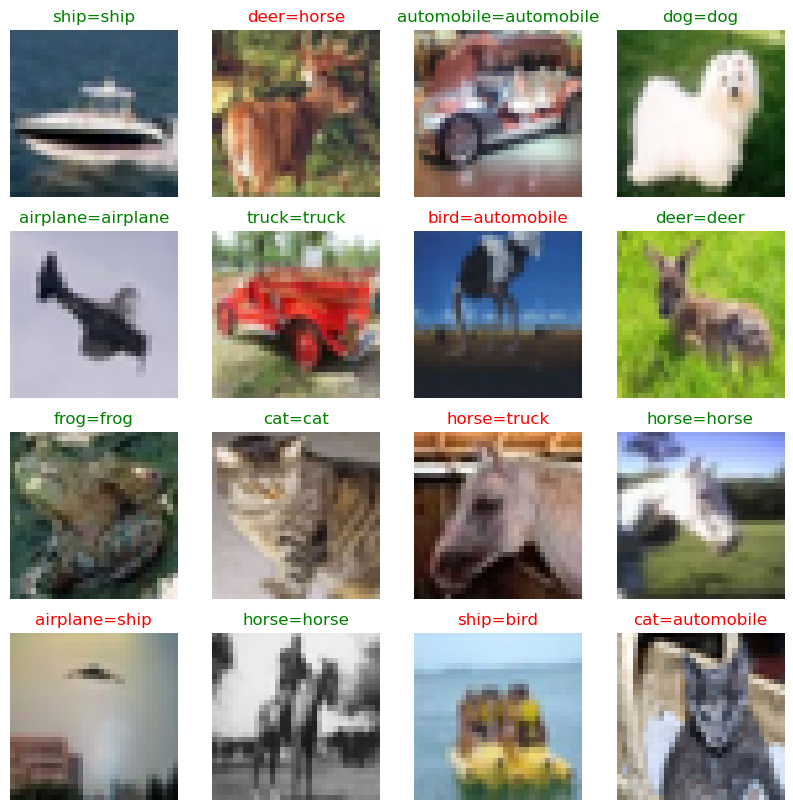

In [37]:
from matplotlib import pyplot as plt
from torch import randint

fig = plt.figure(figsize=(10,10))
for i in range(16):
    img, label = train_dataset[randint(0, len(train_dataset), size=(1,)).item()]
    prediction = mdl(img.unsqueeze(0)).argmax(dim=1).item()
    fig.add_subplot(4,4,i+1)
    plt.imshow(img.permute(1,2,0))
    plt.title(f"{train_dataset.classes[label]}={train_dataset.classes[prediction]}", color="green" if prediction == label else "red")
    plt.axis(False)

In [35]:
torch.save(mdl.state_dict(), "saved_models/cifar10.pth")